In [4]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [19]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [22]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,lifestyle accessories company,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Accessories (45),Accessories (45),Accessories (45),Accessories (45),Accessories (45),Accessories (45),Automotive
1,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,11wells Loading,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,MN,Books and Media
2,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,14th Rose Home,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",Accessories > Bags (61),Accessories > Bags (61),Accessories > Bags (61),Accessories > Bags (61),Automotive
3,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...","Welcome Regal Ware, Inc. Home / Regal / What's...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,West bend,West bend,Health and Beauty
4,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,Wholesale Fleece Clothing 20 Degrees polar wea...,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Philadelphia,Fashion


In [23]:
website_df["category"].count()

5189

In [24]:
classification_col = website_df["category"]

In [57]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    subset = subset.fillna("")
    subset = subset.astype(str)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        pattern = re.escape(phrase)
        phrase_count[phrase] = subset.str.count(pattern, flags=re.IGNORECASE)

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        phrase_count_sum = website_stats.sum()
        if phrase_count_sum == 0:
            continue
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (website_stats[phrase] / phrase_count_sum - alpha)
        year_score += y_n_numerator / y_n_denominator
        website_scores.append(y_n_numerator / y_n_denominator)
        website_category = classification_col[website]
        website_scores_by_category[website_category].append(y_n_numerator / y_n_denominator)
        websites_count += 1

    all_website_scores.append(website_scores)

    print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            print(f"Category {category} had no websites in year {year}")
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {year_score / websites_count}")

100%|██████████| 5189/5189 [00:01<00:00, 4414.13it/s]


Websites count:  177  Number of elements in website_scores:  177
Year 2007 score: 0.648274888330445


100%|██████████| 5189/5189 [00:01<00:00, 4592.00it/s]


Websites count:  187  Number of elements in website_scores:  187
Year 2008 score: 0.6293932962020045


100%|██████████| 5189/5189 [00:01<00:00, 4467.39it/s]


Websites count:  249  Number of elements in website_scores:  249
Year 2009 score: 0.2576145425528518


100%|██████████| 5189/5189 [00:01<00:00, 4411.78it/s]


Websites count:  293  Number of elements in website_scores:  293
Year 2010 score: 0.25294026715679907


100%|██████████| 5189/5189 [00:01<00:00, 4491.43it/s]


Websites count:  179  Number of elements in website_scores:  179
Year 2011 score: 0.37194640326940204


100%|██████████| 5189/5189 [00:01<00:00, 4585.47it/s]


Websites count:  220  Number of elements in website_scores:  220
Year 2012 score: 0.31030865301515653


100%|██████████| 5189/5189 [00:01<00:00, 4415.02it/s]


Websites count:  232  Number of elements in website_scores:  232
Year 2013 score: 0.3925319688005633


100%|██████████| 5189/5189 [00:01<00:00, 4527.27it/s]


Websites count:  242  Number of elements in website_scores:  242
Year 2014 score: 0.3941375347907443


100%|██████████| 5189/5189 [00:01<00:00, 4353.43it/s]


Websites count:  328  Number of elements in website_scores:  328
Year 2015 score: 0.3054086998375852


100%|██████████| 5189/5189 [00:01<00:00, 4262.05it/s]


Websites count:  383  Number of elements in website_scores:  383
Year 2016 score: 0.30512617245875173


100%|██████████| 5189/5189 [00:01<00:00, 4335.13it/s]


Websites count:  345  Number of elements in website_scores:  345
Year 2017 score: 0.6140071882480472


100%|██████████| 5189/5189 [00:01<00:00, 4329.99it/s]


Websites count:  355  Number of elements in website_scores:  355
Year 2018 score: 0.6477759322560205


100%|██████████| 5189/5189 [00:01<00:00, 3965.84it/s]


Websites count:  484  Number of elements in website_scores:  484
Year 2019 score: 0.6578191222931161


100%|██████████| 5189/5189 [00:01<00:00, 3971.20it/s]

Websites count:  574  Number of elements in website_scores:  574
Year 2020 score: 0.6450002346921867


In [58]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])

[0.6482748883304444, 0.6293932962020041, 0.25761454255285215, 0.2529402671567991, 0.37194640326940226, 0.31030865301515664, 0.39253196880056324, 0.3941375347907446, 0.305408699837585, 0.3051261724587518, 0.6140071882480489, 0.6477759322560224, 0.6578191222931165, 0.6450002346921868]


In [59]:
print([np.sum(scores) for scores in all_website_scores])

[114.74465523448868, 117.69654638977477, 64.14602109566019, 74.11149827694214, 66.578406185223, 68.26790366333447, 91.06741676173067, 95.38128341936019, 100.17405354672789, 116.86332405170194, 211.83247994557686, 229.96045595088793, 318.3844551898684, 370.23013471331524]


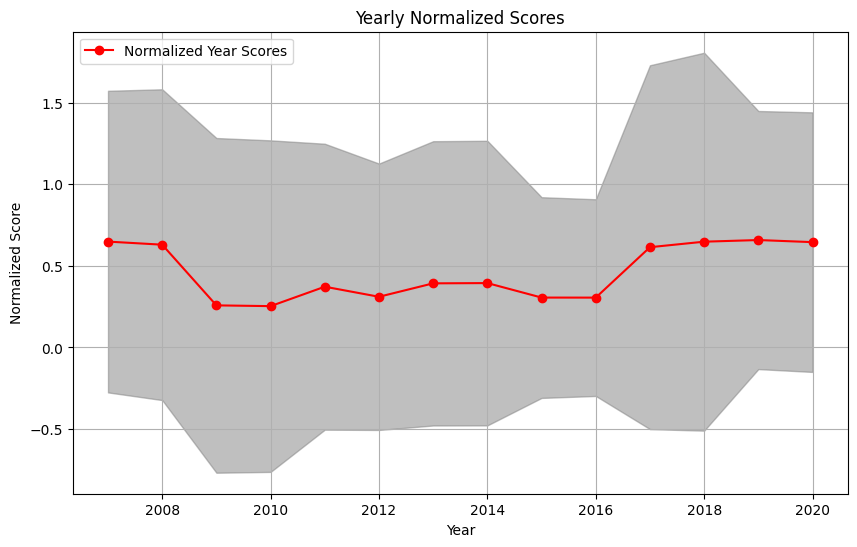

In [60]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]

plt.figure(figsize=(10, 6))
plt.plot(years, normalized_year_scores, marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Sum of Scores')

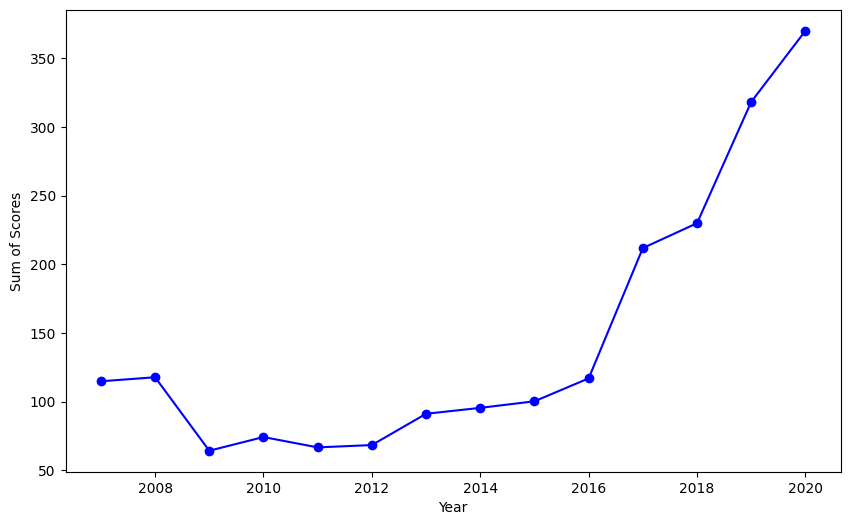

In [61]:
plt.figure(figsize=(10, 6))
value_sums = [np.sum(scores) for scores in all_website_scores]
plt.plot(years, value_sums, marker='o', color='b', label='Yearly Sums')
plt.xlabel('Year')
plt.ylabel('Sum of Scores')

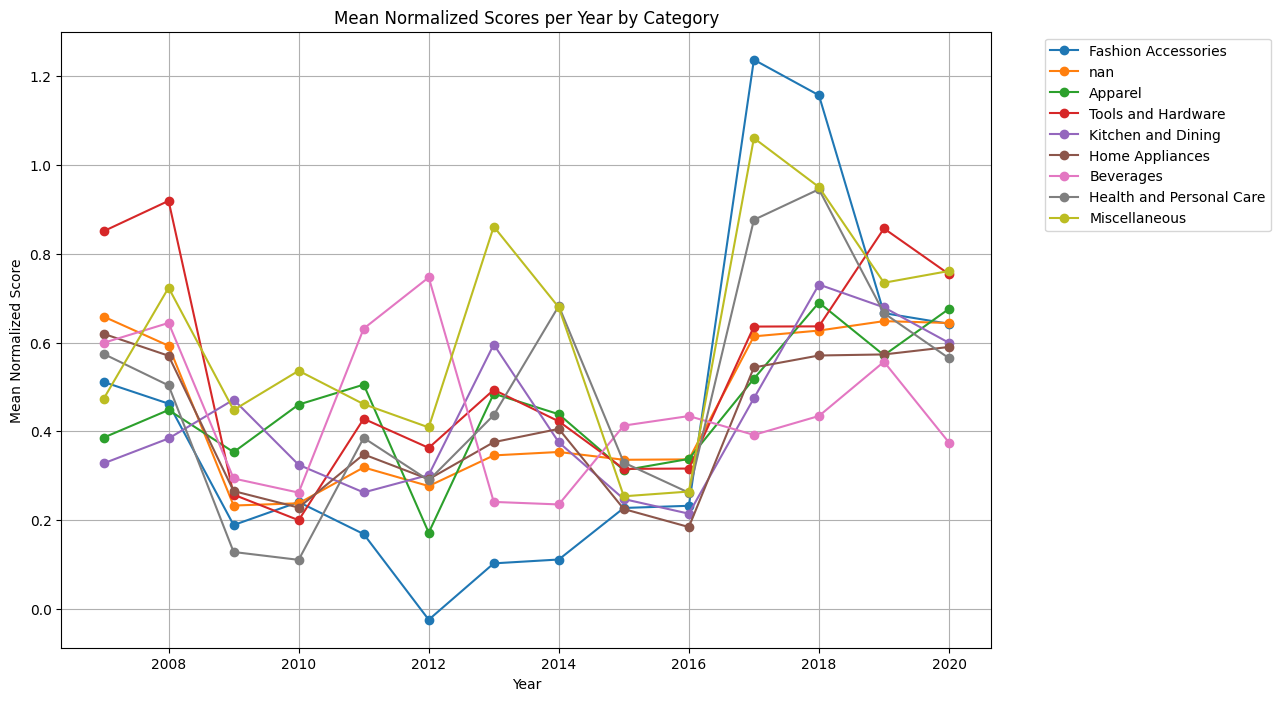

In [62]:
plt.figure(figsize=(12, 8))

for category, scores in categorized_normalized_year_scores.items():
    plt.plot(years, scores, marker='o', label=category)

plt.xlabel('Year')
plt.ylabel('Mean Normalized Score')
plt.title('Mean Normalized Scores per Year by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [63]:
classification_col.count()

2528